In [1]:
from os import walk
from os.path import join
from os import stat
import random
import hashlib
import time

mypath = "D:\Download\enron"

file_names = []

# only store files size bigger than 5K
for root, dirs, files in walk(mypath):
    for f in files:
        fullpath = join(root, f)
        if(stat(fullpath).st_size >= 5000):
            file_names.append(fullpath)

In [2]:
upload_files = random.sample(file_names, k = 1000)
check_files = random.choices(file_names, k = 200)

In [33]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []

In [34]:
def upload_file(upload_list, chunk_size):
    for file in upload_list:
        with open(file, 'rb') as f:
            text = f.read()
        f.close()

        for i in range(0, len(text), chunk_size):
            cloud_hash.append(hashlib.sha256(text[i: i+chunk_size]).hexdigest())
        
def check_file(check_list, chunk_size):
    for file in check_list:
        with open(file, 'rb') as f:
            text = f.read()
        f.close()
        
        for i in range(0, len(text), chunk_size):
            check_hash.append(hashlib.sha256(text[i: i+chunk_size]).hexdigest())
        
        if len(check_hash) % 2 != 0:
            check_hash.append(random.choice(check_hash))

In [35]:
def set_response_list(percent):
    dirty = random.sample(cloud_hash, k = int(percent * len(cloud_hash)))
    
    for chunk in dirty:
        status = random.randint(1, 2)
        response = random.randint(1, 2)
        if response == 1:
            response_list[chunk].update({status: response})
            if status == 1:
                response_list[chunk].update({2: 2})
            else:
                response_list[chunk].update({1: 2})
        elif random.random() >= 0.5:
            response_list[chunk].update({status: response})
            if status == 1:
                response_list[chunk].update({2: random.randint(1, 2)})
            else:
                response_list[chunk].update({1: random.randint(1, 2)})
        else:
            response_list[chunk].update({status: response})
            if status == 1:
                response_list[chunk].update({2: 0})
            else:
                response_list[chunk].update({1: 0})
                
def set_dirty_list(percent):
    dirty_list.extend(random.sample(cloud_hash, k = int(percent * len(cloud_hash))))

In [36]:
def new():
    query = list(set(check_hash.copy()))
    print("after dedup chunk amount:", len(query))
    upload_amount = 0
    
    flex_e0 = []    # flexible, inexist
    flex_e1 = []    # flexible, exist
    fix_s1_e0 = []    # (1,0) -> 1, (1,1) -> 2
    fix_s1_e1 = []    # (1,0) -> 1, (1,1) -> 2
    fix_s2_e0 = []    # (1,1) -> 1, (1,0) -> 2
    fix_s2_e1 = []    # (1,1) -> 1, (1,0) -> 2
    ran_s1_e0 = []    # (1,0) -> RARE, (1,1) -> 2
    ran_s1_e1 = []    # (1,0) -> RARE, (1,1) -> 2
    ran_s2_e0 = []    # (1,1) -> RARE, (1,0) -> 2
    ran_s2_e1 = []    # (1,1) -> RARE, (1,0) -> 2
    fix_2 = []    # fix, all resposne 2
    
    for chunk in query:
        if chunk not in response_list:
            if chunk in cloud_hash:
                flex_e1.append(chunk)
            else:
                flex_e0.append(chunk)
        else:
            if (1 in response_list[chunk].values()) and (1 in list(response_list[chunk].values())[0]) and (chunk not in cloud_hash):
                fix_s1_e0.append(chunk)
            elif (1 in response_list[chunk].values()) and (1 in list(response_list[chunk].values())[0]) and (chunk in cloud_hash):
                fix_s1_e1.append(chunk)
            elif (1 in response_list[chunk].values()) and (1 in list(response_list[chunk].values())[1]) and (chunk not in cloud_hash):
                fix_s2_e0.append(chunk)
            elif (1 in response_list[chunk].values()) and (1 in list(response_list[chunk].values())[1]) and (chunk in cloud_hash):
                fix_s2_e1.append(chunk)
            elif (0 in response_list[chunk].values()) and (0 in list(response_list[chunk].values())[0]) and (chunk not in cloud_hash):
                ran_s1_e0.append(chunk)
            elif (0 in response_list[chunk].values()) and (0 in list(response_list[chunk].values())[0]) and (chunk in cloud_hash):
                ran_s1_e1.append(chunk)
            elif (0 in response_list[chunk].values()) and (0 in list(response_list[chunk].values())[1]) and (chunk not in cloud_hash):
                ran_s2_e0.append(chunk)
            elif (0 in response_list[chunk].values()) and (0 in list(response_list[chunk].values())[1]) and (chunk in cloud_hash):
                ran_s1_e1.append(chunk)
            else:
                fix_2.append(chunk)
                
    while len(fix_s1_e0) > 0:    # (1,0) -> 1
        if len(fix_s1_e1) > 0:
            fix_s1_e0.pop()
            fix_s1_e1.pop()
            upload_amount += 1
        elif len(ran_s1_e1) > 0:
            fix_s1_e0.pop()
            ran_s1_e1.pop()
            upload_amount += 1
        elif len(flex_e1) > 0:
            fix_s1_e0.pop()
            flex_e1.pop()
            upload_amount += 1
        else:
            break
            
    while len(fix_s1_e1) > 0:
        if len(fix_s1_e0) > 0:
            fix_s1_e1.pop()
            fix_s1_e0.pop()
            upload_amount += 1
        elif len(ran_s1_e0) > 0:
            fix_s1_e1.pop()
            ran_s1_e0.pop()
            upload_amount += 1
        elif len(flex_e0) > 0:
            fix_s1_e1.pop()
            flex_e0.pop()
            upload_amount += 1
        else:
            break
            
    while len(fix_s2_e1) > 0:    # (1,1) -> 1
        if len(fix_s2_e1) >= 2:
            fix_s2_e1.pop()
            fix_s2_e1.pop()
            upload_amount += 1
        elif len(ran_s2_e1) > 0:
            fix_s2_e1.pop()
            ran_s2_e1.pop()
            upload_amount += 1
        elif len(flex_e1) > 0:
            fix_s2_e1.pop()
            flex_e1.pop()
            upload_amount += 1
        else:
            break
        
    while len(ran_s1_e0) > 0:    # (1,0) -> 1 or RARE
        if len(fix_s1_e1) > 0:
            ran_s1_e0.pop()
            fix_s1_e1.pop()
            upload_amount += 1
        elif len(ran_s1_e1) > 0:
            ran_s1_e0.pop()
            ran_s1_e1.pop()
            upload_amount += random.randint(1, 2)
        elif len(flex_e1) > 0:
            ran_s1_e0.pop()
            flex_e1.pop()
            upload_amount += random.randint(1, 2)
        else:
            break
            
    while len(ran_s1_e1) > 0:    # (1,0) -> 1 or RARE
        if len(fix_s1_e0) > 0:
            ran_s1_e1.pop()
            fix_s1_e0.pop()
            upload_amount += 1
        elif len(ran_s1_e0) > 0:
            ran_s1_e1.pop()
            ran_s1_e0.pop()
            upload_amount += random.randint(1, 2)
        elif len(flex_e0) > 0:
            ran_s1_e1.pop()
            flex_e0.pop()
            upload_amount += random.randint(1, 2)
        else:
            break
            
    while len(ran_s2_e1) > 0:    # (1,1) -> 1 or RARE
        if len(fix_s2_e1) > 0:
            ran_s2_e1.pop()
            fix_s2_e1.pop()
            upload_amount += 1
        elif len(ran_s2_e1) >= 2:
            ran_s2_e1.pop()
            ran_s2_e1.pop()
            upload_amount += random.randint(1, 2)
        elif len(flex_e1) > 0:
            ran_s2_e1.pop()
            flex_e1.pop()
            upload_amount += random.randint(1, 2)
        else:
            break
            
    while len(flex_e0) > 0:    # return 1 or RARE
        if len(fix_s1_e1) > 0:
            flex_e0.pop()
            fix_s1_e1.pop()
            upload_amount += 1
        elif len(ran_s1_e1) > 0:
            flex_e0.pop()
            ran_s1_e1.pop()
            upload_amount += random.randint(1, 2)
        elif len(flex_e1) > 0:
            flex_e0.pop()
            flex_e1.pop()
            upload_amount += random.randint(1, 2)
        else:
            break
            
    while len(flex_e1) > 0:    # return 1 or RARE
        if len(fix_s1_e0) > 0:
            flex_e1.pop()
            fix_s1_e0.pop()
            upload_amount += 1
        elif len(fix_s2_e1) > 0:
            flex_e1.pop()
            fix_s2_e1.pop()
            upload_amount += 1
        elif len(ran_s1_e0) > 0:
            flex_e1.pop()
            ran_s1_e0.pop()
            upload_amount += random.randint(1, 2)
        elif len(ran_s2_e1) > 0:
            flex_e1.pop()
            ran_s2_e1.pop()
            upload_amount += random.randint(1, 2)
        elif len(flex_e0) > 0:
            flex_e1.pop()
            flex_e0.pop()
            upload_amount += random.randint(1, 2)
        elif len(flex_e1) >= 2:
            flex_e1.pop()
            flex_e1.pop()
            upload_amount += random.randint(1, 2)
        else:
            break
            
    remain_list = flex_e0 + flex_e1 + fix_s1_e0 + fix_s1_e1 + fix_s2_e0 + fix_s2_e1 + ran_s1_e0 + ran_s1_e1 + ran_s2_e0 + ran_s2_e1 + fix_2
    upload_amount += len(remain_list)
    
    return upload_amount

def rare():
    upload_amount = 0
    
    for i in range(0, len(check_hash), 2):
        if (check_hash[i] in dirty_list) or (check_hash[i+1] in dirty_list):
            upload_amount += 2
        elif (check_hash[i] not in cloud_hash) and (check_hash[i+1] not in cloud_hash):
            upload_amount += 2
        else:
            upload_amount += random.randint(1, 2)
    
    return upload_amount

def zeus():
    upload_amount = 0
    
    for i in range(0, len(check_hash), 2):
        if (check_hash[i] in dirty_list) or (check_hash[i+1] in dirty_list):
            upload_amount += 2
        elif (check_hash[i] not in cloud_hash) and (check_hash[i+1] not in cloud_hash):
            upload_amount += 2
        else:
            upload_amount += 1
    
    return upload_amount

def dedup():
    upload_amount = 0
    
    for chunk in check_hash:
        if chunk not in cloud_hash:
            upload_amount += 1
    
    return upload_amount

In [37]:
new_cost = []
rare_cost = []
zeus_cost = []
dedup_cost = []
chunk_amount = []

In [38]:
upload_file(upload_files, 128)
check_file(check_files, 128)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 20634
hash existence amount: 692
after dedup chunk amount: 20385


In [39]:
cloud_hash = []
check_hash = []
upload_file(upload_files, 256)
check_file(check_files, 256)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 10424
hash existence amount: 323
after dedup chunk amount: 10256


In [40]:
cloud_hash = []
check_hash = []
upload_file(upload_files, 512)
check_file(check_files, 512)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 5320
hash existence amount: 147
after dedup chunk amount: 5182


In [41]:
cloud_hash = []
check_hash = []
upload_file(upload_files, 1024)
check_file(check_files, 1024)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 2736
hash existence amount: 69
after dedup chunk amount: 2645


In [42]:
cloud_hash = []
check_hash = []
upload_file(upload_files, 2048)
check_file(check_files, 2048)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 1466
hash existence amount: 31
after dedup chunk amount: 1360


In [43]:
cloud_hash = []
check_hash = []
upload_file(upload_files, 4096)
check_file(check_files, 4096)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 800
hash existence amount: 14
after dedup chunk amount: 729


In [44]:
import numpy as np

chunk_size = np.array([128, 256, 512, 1024, 2048, 4096])
no_dedup_byte = np.multiply(chunk_amount, chunk_size)
new_byte = np.multiply(np.array(new_cost), chunk_size)
rare_byte = np.multiply(np.array(rare_cost), chunk_size)
zeus_byte = np.multiply(np.array(zeus_cost), chunk_size)
dedup_byte = np.multiply(np.array(dedup_cost), chunk_size)
new_upload_percentage = np.divide((np.array(new_cost) * 100), chunk_amount)
rare_upload_percentage = np.divide((np.array(rare_cost) * 100), chunk_amount)
zeus_upload_percentage = np.divide((np.array(zeus_cost) * 100), chunk_amount)
dedup_upload_percentage = np.divide((np.array(dedup_cost) * 100), chunk_amount)
print("new_algo_upload_amount:", new_cost, "new_algo_upload_percentage:", new_upload_percentage, "new_algo_cost:", new_byte)
print("rare_upload_amount:", rare_cost, "rare_upload_percentage:", rare_upload_percentage, "rare_cost:", rare_byte)
print("zeus_upload_amount:", zeus_cost, "zeus_upload_percentage:", zeus_upload_percentage, "zeus_cost:", zeus_byte)
print("dedup_upload_amount:", dedup_cost, "dedup_upload_percentage:", dedup_upload_percentage, "dedup_cost:", dedup_byte)

new_algo_upload_amount: [20043, 10094, 5115, 2609, 1349, 719] new_algo_upload_percentage: [97.13579529 96.8342287  96.14661654 95.35818713 92.01909959 89.875     ] new_algo_cost: [2565504 2584064 2618880 2671616 2762752 2945024]
rare_upload_amount: [20452, 10328, 5281, 2719, 1455, 796] rare_upload_percentage: [99.11796065 99.07904835 99.26691729 99.37865497 99.24965894 99.5       ] rare_cost: [2617856 2643968 2703872 2784256 2979840 3260416]
zeus_upload_amount: [20252, 10248, 5238, 2696, 1446, 791] zeus_upload_percentage: [98.14868663 98.31158864 98.45864662 98.5380117  98.63574352 98.875     ] zeus_cost: [2592256 2623488 2681856 2760704 2961408 3239936]
dedup_upload_amount: [19928, 10100, 5172, 2666, 1433, 786] dedup_upload_percentage: [96.57846273 96.89178818 97.21804511 97.44152047 97.74897681 98.25      ] dedup_cost: [2550784 2585600 2648064 2729984 2934784 3219456]


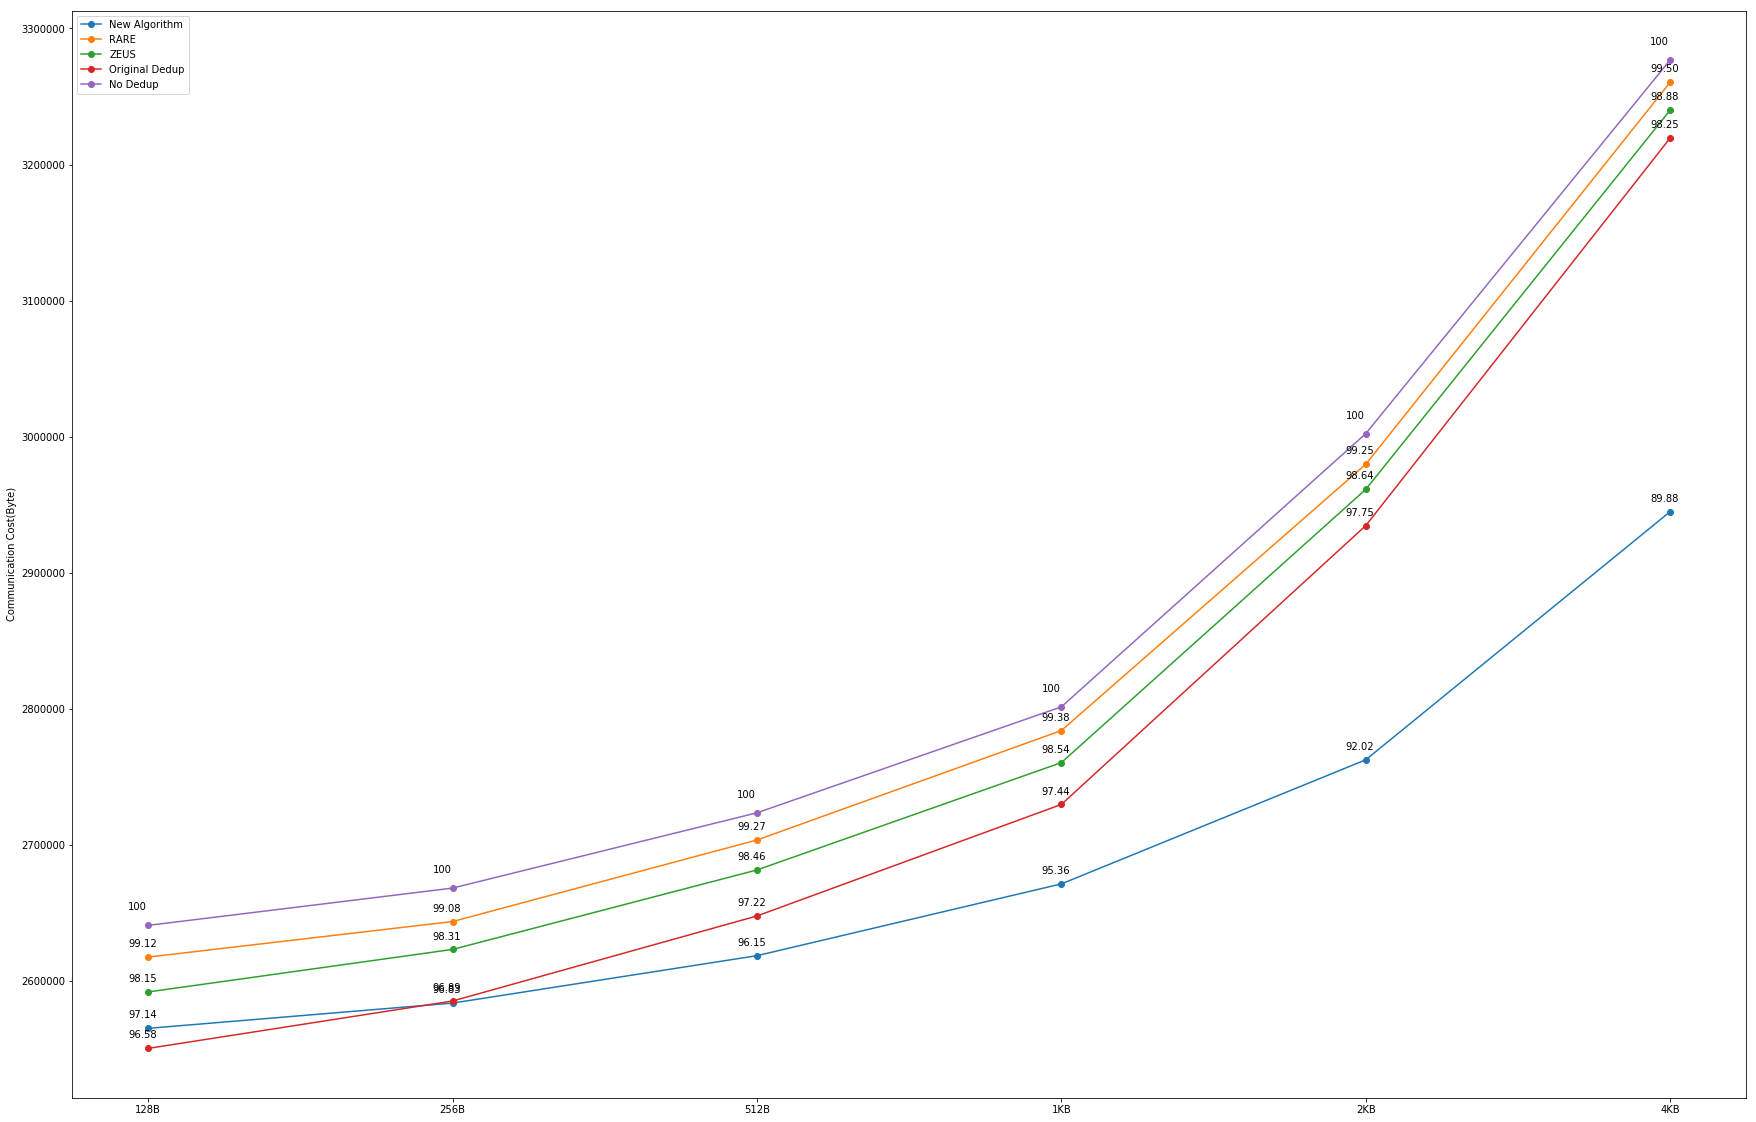

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (30, 20))
# plt.figure(dpi = 120)
xs = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(xs, new_byte, '-o', label = 'New Algorithm')
for x, y, z in zip(xs, new_upload_percentage, new_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')

plt.plot(xs, rare_byte, '-o', label = 'RARE')
for x, y, z in zip(xs, rare_upload_percentage, rare_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')

plt.plot(xs, zeus_byte, '-o', label = 'ZEUS')
for x, y, z in zip(xs, zeus_upload_percentage, zeus_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, dedup_byte, '-o', label = 'Original Dedup')
for x, y, z in zip(xs, dedup_upload_percentage, dedup_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, no_dedup_byte, '-o', label = 'No Dedup')
for x, y in zip(xs, no_dedup_byte):
    plt.annotate("100", xy = (x,y), xytext=(-20, 15), textcoords='offset points')
    
plt.legend()
plt.ylabel('Communication Cost(Byte)')
# plt.show()
plt.savefig('result.png')

In [46]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
new_cost = []
rare_cost = []
zeus_cost = []
dedup_cost = []
chunk_amount = []

set_response_list(0.1)
set_dirty_list(0.1)
upload_file(upload_files, 128)
check_file(check_files, 128)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 20634
hash existence amount: 692
after dedup chunk amount: 20385


In [47]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
set_response_list(0.1)
set_dirty_list(0.1)
upload_file(upload_files, 256)
check_file(check_files, 256)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 10424
hash existence amount: 323
after dedup chunk amount: 10256


In [48]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
set_response_list(0.1)
set_dirty_list(0.1)
upload_file(upload_files, 512)
check_file(check_files, 512)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 5320
hash existence amount: 147
after dedup chunk amount: 5182


In [49]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
set_response_list(0.1)
set_dirty_list(0.1)
upload_file(upload_files, 1024)
check_file(check_files, 1024)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 2736
hash existence amount: 69
after dedup chunk amount: 2645


In [50]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
set_response_list(0.1)
set_dirty_list(0.1)
upload_file(upload_files, 2048)
check_file(check_files, 2048)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 1466
hash existence amount: 31
after dedup chunk amount: 1360


In [51]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
set_response_list(0.1)
set_dirty_list(0.1)
upload_file(upload_files, 4096)
check_file(check_files, 4096)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 800
hash existence amount: 14
after dedup chunk amount: 729


In [52]:
chunk_size = np.array([128, 256, 512, 1024, 2048, 4096])
no_dedup_byte = np.multiply(chunk_amount, chunk_size)
new_byte = np.multiply(np.array(new_cost), chunk_size)
rare_byte = np.multiply(np.array(rare_cost), chunk_size)
zeus_byte = np.multiply(np.array(zeus_cost), chunk_size)
dedup_byte = np.multiply(np.array(dedup_cost), chunk_size)
new_upload_percentage = np.divide((np.array(new_cost) * 100), chunk_amount)
rare_upload_percentage = np.divide((np.array(rare_cost) * 100), chunk_amount)
zeus_upload_percentage = np.divide((np.array(zeus_cost) * 100), chunk_amount)
dedup_upload_percentage = np.divide((np.array(dedup_cost) * 100), chunk_amount)
print("new_algo_upload_amount:", new_cost, "new_algo_upload_percentage:", new_upload_percentage, "new_algo_cost:", new_byte)
print("rare_upload_amount:", rare_cost, "rare_upload_percentage:", rare_upload_percentage, "rare_cost:", rare_byte)
print("zeus_upload_amount:", zeus_cost, "zeus_upload_percentage:", zeus_upload_percentage, "zeus_cost:", zeus_byte)
print("dedup_upload_amount:", dedup_cost, "dedup_upload_percentage:", dedup_upload_percentage, "dedup_cost:", dedup_byte)

new_algo_upload_amount: [20024, 10085, 5105, 2611, 1343, 721] new_algo_upload_percentage: [97.04371426 96.74788949 95.95864662 95.43128655 91.60982265 90.125     ] new_algo_cost: [2563072 2581760 2613760 2673664 2750464 2953216]
rare_upload_amount: [20453, 10337, 5279, 2714, 1455, 793] rare_upload_percentage: [99.12280702 99.16538757 99.22932331 99.19590643 99.24965894 99.125     ] rare_cost: [2617984 2646272 2702848 2779136 2979840 3248128]
zeus_upload_amount: [20252, 10248, 5236, 2697, 1446, 790] zeus_upload_percentage: [98.14868663 98.31158864 98.42105263 98.5745614  98.63574352 98.75      ] zeus_cost: [2592256 2623488 2680832 2761728 2961408 3235840]
dedup_upload_amount: [19928, 10100, 5170, 2667, 1433, 785] dedup_upload_percentage: [96.57846273 96.89178818 97.18045113 97.47807018 97.74897681 98.125     ] dedup_cost: [2550784 2585600 2647040 2731008 2934784 3215360]


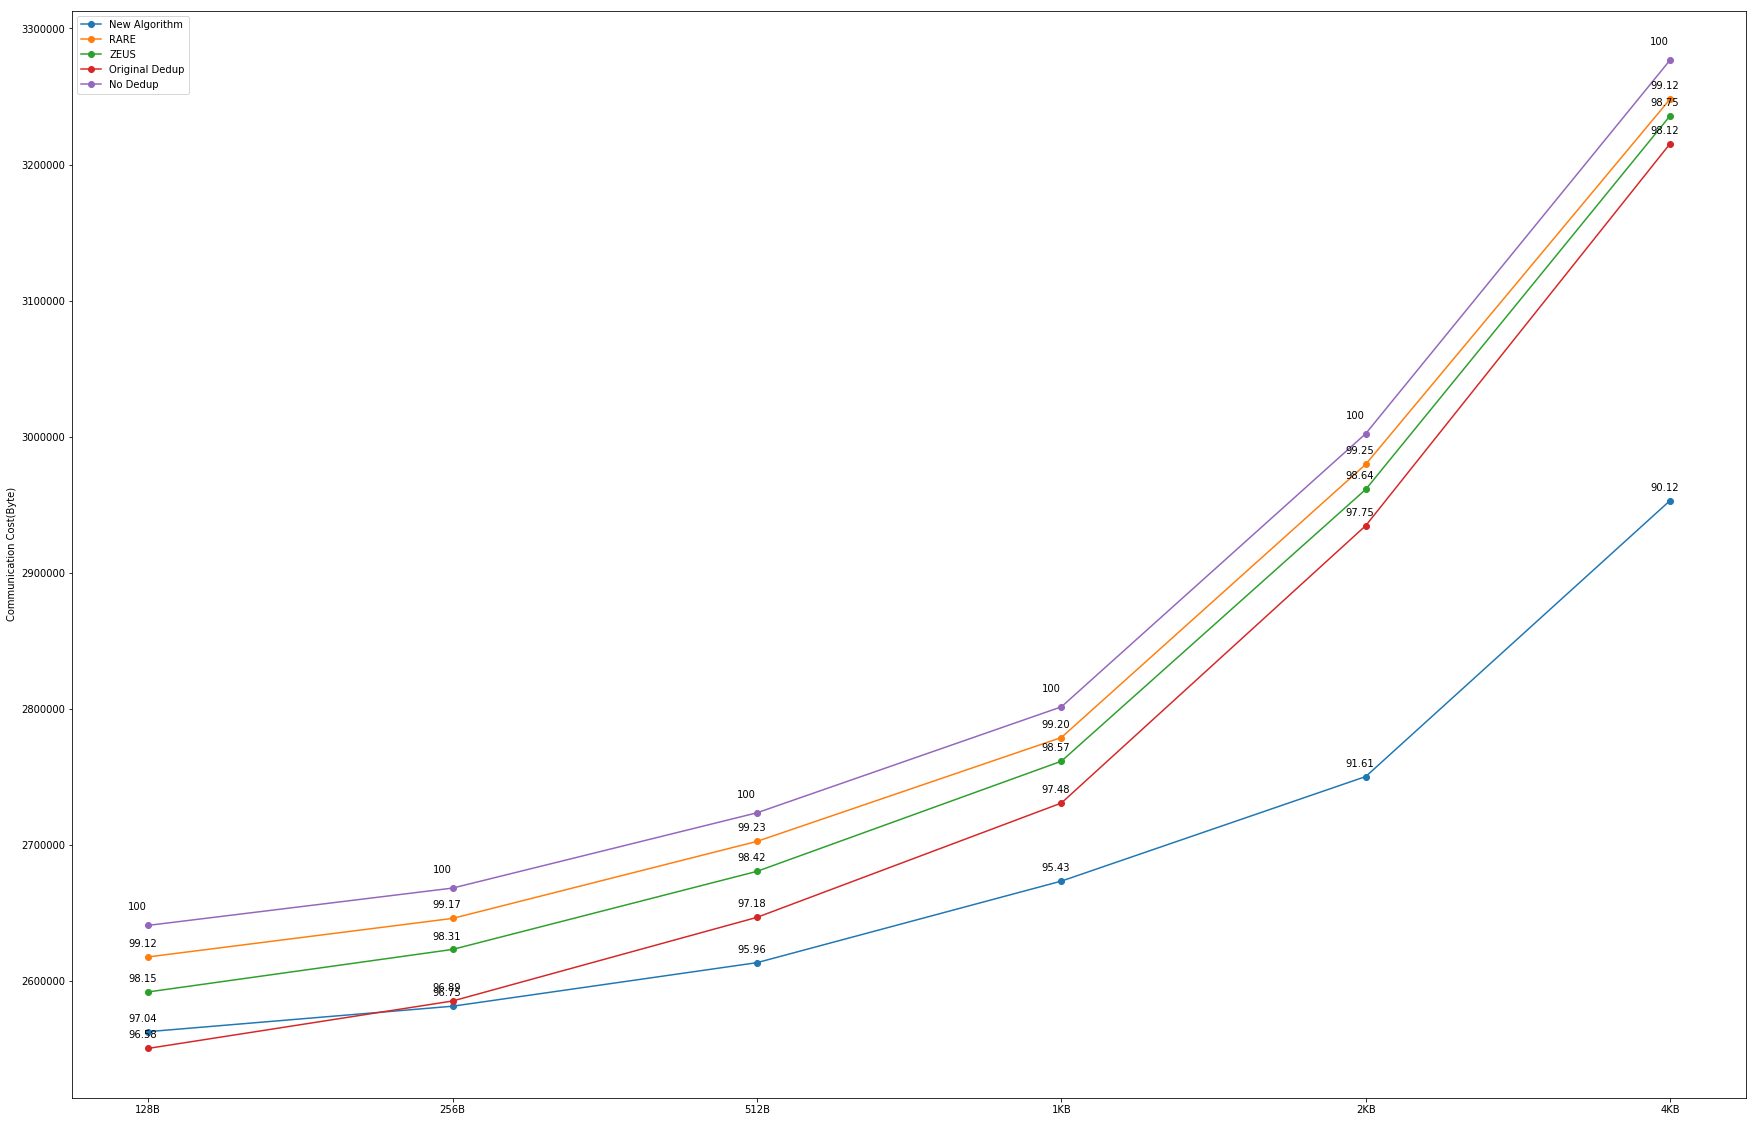

In [53]:
plt.figure(figsize = (30, 20))
# plt.figure(dpi = 120)
xs = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(xs, new_byte, '-o', label = 'New Algorithm')
for x, y, z in zip(xs, new_upload_percentage, new_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')

plt.plot(xs, rare_byte, '-o', label = 'RARE')
for x, y, z in zip(xs, rare_upload_percentage, rare_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')

plt.plot(xs, zeus_byte, '-o', label = 'ZEUS')
for x, y, z in zip(xs, zeus_upload_percentage, zeus_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, dedup_byte, '-o', label = 'Original Dedup')
for x, y, z in zip(xs, dedup_upload_percentage, dedup_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, no_dedup_byte, '-o', label = 'No Dedup')
for x, y in zip(xs, no_dedup_byte):
    plt.annotate("100", xy = (x,y), xytext=(-20, 15), textcoords='offset points')
    
plt.legend()
plt.ylabel('Communication Cost(Byte)')
# plt.show()
plt.savefig('result_10%.png')

In [54]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
new_cost = []
rare_cost = []
zeus_cost = []
dedup_cost = []
chunk_amount = []

set_response_list(0.25)
set_dirty_list(0.25)
upload_file(upload_files, 128)
check_file(check_files, 128)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 20634
hash existence amount: 692
after dedup chunk amount: 20385


In [55]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
set_response_list(0.25)
set_dirty_list(0.25)
upload_file(upload_files, 256)
check_file(check_files, 256)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 10424
hash existence amount: 323
after dedup chunk amount: 10256


In [56]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
set_response_list(0.25)
set_dirty_list(0.25)
upload_file(upload_files, 512)
check_file(check_files, 512)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 5320
hash existence amount: 147
after dedup chunk amount: 5182


In [57]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
set_response_list(0.25)
set_dirty_list(0.25)
upload_file(upload_files, 1024)
check_file(check_files, 1024)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 2736
hash existence amount: 69
after dedup chunk amount: 2645


In [58]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
set_response_list(0.25)
set_dirty_list(0.25)
upload_file(upload_files, 2048)
check_file(check_files, 2048)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 1466
hash existence amount: 31
after dedup chunk amount: 1360


In [59]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
set_response_list(0.25)
set_dirty_list(0.25)
upload_file(upload_files, 4096)
check_file(check_files, 4096)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 800
hash existence amount: 14
after dedup chunk amount: 729


In [60]:
chunk_size = np.array([128, 256, 512, 1024, 2048, 4096])
no_dedup_byte = np.multiply(chunk_amount, chunk_size)
new_byte = np.multiply(np.array(new_cost), chunk_size)
rare_byte = np.multiply(np.array(rare_cost), chunk_size)
zeus_byte = np.multiply(np.array(zeus_cost), chunk_size)
dedup_byte = np.multiply(np.array(dedup_cost), chunk_size)
new_upload_percentage = np.divide((np.array(new_cost) * 100), chunk_amount)
rare_upload_percentage = np.divide((np.array(rare_cost) * 100), chunk_amount)
zeus_upload_percentage = np.divide((np.array(zeus_cost) * 100), chunk_amount)
dedup_upload_percentage = np.divide((np.array(dedup_cost) * 100), chunk_amount)
print("new_algo_upload_amount:", new_cost, "new_algo_upload_percentage:", new_upload_percentage, "new_algo_cost:", new_byte)
print("rare_upload_amount:", rare_cost, "rare_upload_percentage:", rare_upload_percentage, "rare_cost:", rare_byte)
print("zeus_upload_amount:", zeus_cost, "zeus_upload_percentage:", zeus_upload_percentage, "zeus_cost:", zeus_byte)
print("dedup_upload_amount:", dedup_cost, "dedup_upload_percentage:", dedup_upload_percentage, "dedup_cost:", dedup_byte)

new_algo_upload_amount: [20052, 10095, 5107, 2610, 1343, 720] new_algo_upload_percentage: [97.17941262 96.84382195 95.9962406  95.39473684 91.60982265 90.        ] new_algo_cost: [2566656 2584320 2614784 2672640 2750464 2949120]
rare_upload_amount: [20452, 10329, 5282, 2712, 1456, 793] rare_upload_percentage: [99.11796065 99.0886416  99.28571429 99.12280702 99.31787176 99.125     ] rare_cost: [2617856 2644224 2704384 2777088 2981888 3248128]
zeus_upload_amount: [20255, 10249, 5236, 2695, 1448, 791] zeus_upload_percentage: [98.16322574 98.32118189 98.42105263 98.50146199 98.77216917 98.875     ] zeus_cost: [2592640 2623744 2680832 2759680 2965504 3239936]
dedup_upload_amount: [19931, 10101, 5170, 2665, 1435, 786] dedup_upload_percentage: [96.59300184 96.90138143 97.18045113 97.40497076 97.88540246 98.25      ] dedup_cost: [2551168 2585856 2647040 2728960 2938880 3219456]


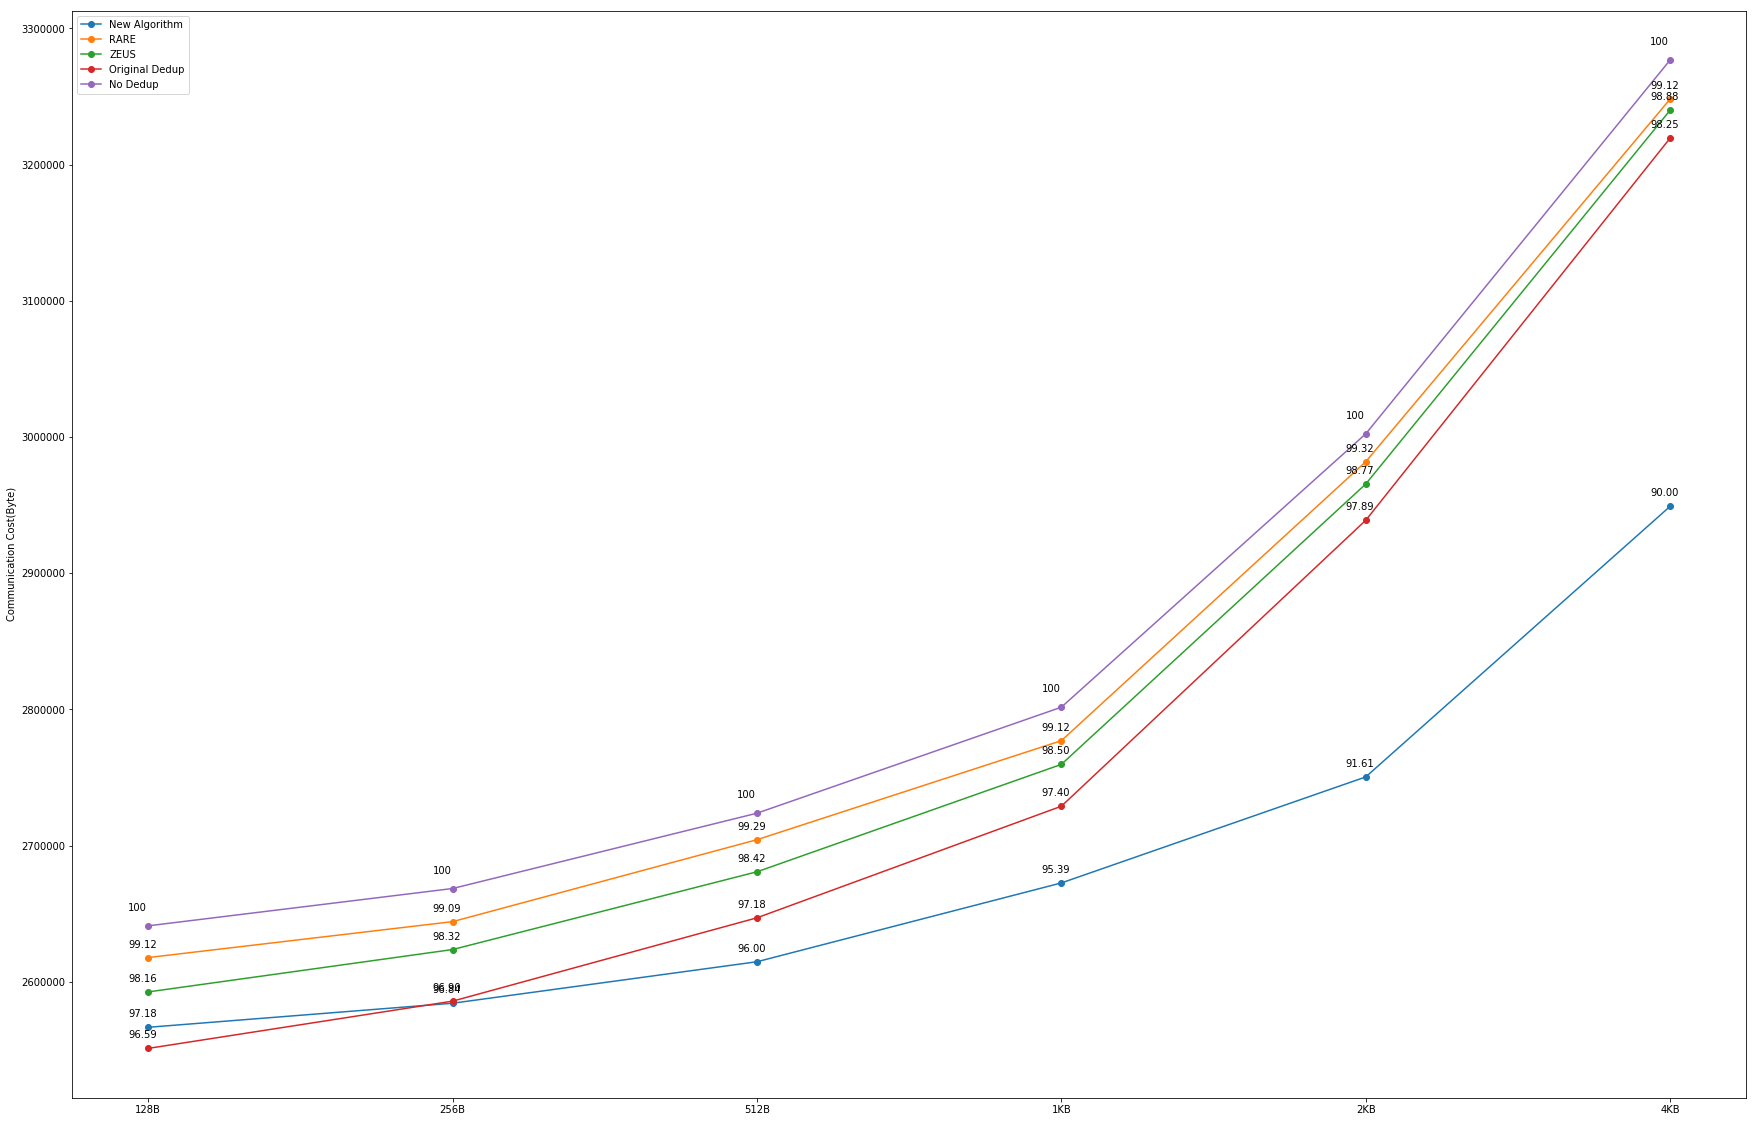

In [61]:
plt.figure(figsize = (30, 20))
# plt.figure(dpi = 120)
xs = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(xs, new_byte, '-o', label = 'New Algorithm')
for x, y, z in zip(xs, new_upload_percentage, new_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')

plt.plot(xs, rare_byte, '-o', label = 'RARE')
for x, y, z in zip(xs, rare_upload_percentage, rare_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')

plt.plot(xs, zeus_byte, '-o', label = 'ZEUS')
for x, y, z in zip(xs, zeus_upload_percentage, zeus_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, dedup_byte, '-o', label = 'Original Dedup')
for x, y, z in zip(xs, dedup_upload_percentage, dedup_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, no_dedup_byte, '-o', label = 'No Dedup')
for x, y in zip(xs, no_dedup_byte):
    plt.annotate("100", xy = (x,y), xytext=(-20, 15), textcoords='offset points')
    
plt.legend()
plt.ylabel('Communication Cost(Byte)')
# plt.show()
plt.savefig('result_25%.png')